<h1>Training and Testing Model</h1>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import csv

/Users/theo/opt/anaconda3/envs/fp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/theo/opt/anaconda3/envs/fp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/theo/opt/anaconda3/envs/fp/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/theo/opt/anaconda3/envs/fp/lib/python3.6/s

In [2]:
tokenizer = Tokenizer(filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
# Import the datatext file containing pre-proccessed texts.
textFile = pd.read_csv('sens13.csv', index_col=False)
corpus = textFile['Text']
# Split 80:20 train:test data
train_data, test_data = train_test_split(corpus, test_size=0.2, random_state=10)
# # Create tokenizer/word index
tokenizer.fit_on_texts(train_data)
total_words = len(tokenizer.word_index) + 1 

In [3]:
input_sequences = []
for line in train_data:
# Converts each line to a token list
    token_list = tokenizer.texts_to_sequences([line])[0]
    if(len(token_list)>0):
# remove the lable(key) and save it for use later
        key = token_list[-1]
        token_list.pop()
# Then will iterate over this list of tokens and create a number of n-grams sequences, 
# it will add the label(key) to the end of the tokens again meaning the algorithm will always predict the label
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            n_gram_sequence.append(key)
            input_sequences.append(n_gram_sequence)
# Calculate longest token array
max_sequence_len = max([len(x) for x in input_sequences])
# Pad all lines with leading 0s so all arrays are the same length
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [4]:
textTokens, labels = input_sequences[:,:-1],input_sequences[:,-1]
# creates a one hot encoded version of the topic label within the word list
oneHotLabel = tf.keras.utils.to_categorical(labels, num_classes=total_words)

Model build - described in report.

In [5]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(textTokens, oneHotLabel, epochs=30, verbose=1)

/Users/theo/opt/anaconda3/envs/fp/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
47962/47962 [==============================] - 379s 8ms/step - loss: 1.9291 - acc: 0.1631
Epoch 2/30
47962/47962 [==============================] - 398s 8ms/step - loss: 1.9149 - acc: 0.1647
Epoch 3/30
47962/47962 [==============================] - 398s 8ms/step - loss: 1.9076 - acc: 0.1690
Epoch 4/30
47962/47962 [==============================] - 405s 8ms/step - loss: 1.9197 - acc: 0.1692
Epoch 5/30
47962/47962 [==============================] - 418s 9ms/step - loss: 1.7151 - acc: 0.2780
Epoch 6/30
47962/47962 [==============================] - 408s 9ms/step - loss: 0.7940 - acc: 0.7231
Epoch 7/30
47962/47962 [==============================] - 415s 9ms/step - loss: 0.5125 - acc: 0.8258
Epoch 8/30
47962/47962 [==============================] - 414s 9ms/step - loss: 0.4249 - acc: 0.8562
Epoch 9/30
47962/47962 [==============================] - 425s 9ms/step - loss: 0.3818 - acc: 0.8715
Epoch 10/30
47962/47962 [==============================] - 448s 9ms/step - loss: 0.3453 - a

[]

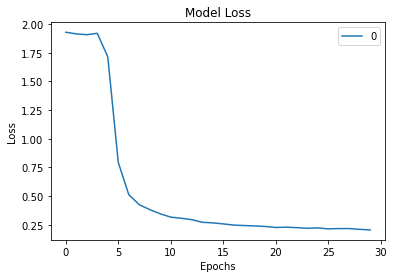

In [6]:
import matplotlib
model_loss = pd.DataFrame(history.history["loss"])
ax = model_loss.plot(title='Model Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.plot()

[]

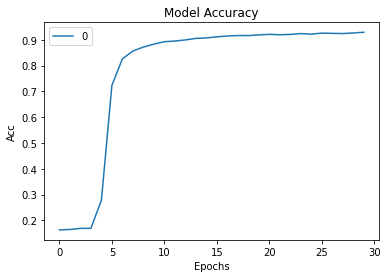

In [7]:
import matplotlib
model_acc = pd.DataFrame(history.history["acc"])
ax = model_acc.plot(title='Model Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Acc")
ax.plot()

<h3>Unseen dataset validation</h3>

In [8]:
test_data
counter = 0
corpusLen = len(test_data)
for line in test_data:
    next_words = 1
    label = line.split()[-1]
    line = line.rsplit(' ', 1)[0]
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([line])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
#  print(output_word + ' ' + label)
    if(output_word == label):
        counter+=1
#     line += " " + output_word
#     print(line)
acc = (counter/corpusLen)*100
print('Acc: ' + str(acc))

Acc: 76.66666666666667


In [9]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 100)            1104200   
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 11042)             3323642   
Total params: 4,729,042
Trainable params: 4,729,042
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model.save('LSTM-6.h5')